In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
from itertools import product
from scipy.interpolate import CubicSpline

font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)
# matplotlib에 적용
plt.rcParams['font.family'] = font_prop.get_name()

In [3]:
df = pd.read_csv('./data/DS_data_2.csv').copy()
df

,판매일시,테이블코드,타입,결제 합계,상품명,상품코드,수량,매출,공급가액,부가세
0,2025-05-06 21:02:21,6,판매,"12,000",가지솥밥,1,1,"12,000",10909,1091
1,2025-05-06 21:02:15,6,판매,"13,000",우삼겹솥밥,24,1,"13,000",11818,1182
2,2025-05-06 20:59:51,13,판매,"37,000",사이다,64,1,"2,000",33636,3364
3,2025-05-06 20:59:51,13,판매,"37,000",스테이크솥밥,3,1,"17,000",33636,3364
4,2025-05-06 20:59:51,13,판매,"37,000",사이다,64,1,"2,000",33636,3364
...,...,...,...,...,...,...,...,...,...,...
39970,2024-08-23 11:59:53,1,판매,"68,000",우삼겹스키야키,7,1,"16,000",61818,6182
39971,2024-08-23 11:50:13,7,판매,"29,000",스테이크솥밥,3,1,"17,000",26364,2636
39972,2024-08-23 11:50:13,7,판매,"29,000",가지솥밥,1,1,"12,000",26364,2636
39973,2024-08-23 11:49:46,3,판매,"24,000",마늘쫑솥밥,31,1,"12,000",21818,2182


# 영업시간에 맞춰 전처리

In [4]:
df['판매일시'] = pd.to_datetime(df['판매일시'])
#영업시간에 맞추어 이상치 필터링 (예약 혹은 과하게 많은 수량주문 제거 )
df['판매시간'] = df['판매일시'].dt.hour
df['판매일'] = df['판매일시'].dt.day

# 영업시간(11~22시)이외 주문 분리
예약주문_df = df[(df['판매시간'] < 11) | (df['판매시간'] > 21)]
df= df[(df['판매시간'] >= 11) & (df['판매시간'] <= 22)].copy()
df.reset_index(drop=True)
df

,판매일시,테이블코드,타입,결제 합계,상품명,상품코드,수량,매출,공급가액,부가세,판매시간,판매일
0,2025-05-06 21:02:21,6,판매,"12,000",가지솥밥,1,1,"12,000",10909,1091,21,6
1,2025-05-06 21:02:15,6,판매,"13,000",우삼겹솥밥,24,1,"13,000",11818,1182,21,6
2,2025-05-06 20:59:51,13,판매,"37,000",사이다,64,1,"2,000",33636,3364,20,6
3,2025-05-06 20:59:51,13,판매,"37,000",스테이크솥밥,3,1,"17,000",33636,3364,20,6
4,2025-05-06 20:59:51,13,판매,"37,000",사이다,64,1,"2,000",33636,3364,20,6
...,...,...,...,...,...,...,...,...,...,...,...,...
39970,2024-08-23 11:59:53,1,판매,"68,000",우삼겹스키야키,7,1,"16,000",61818,6182,11,23
39971,2024-08-23 11:50:13,7,판매,"29,000",스테이크솥밥,3,1,"17,000",26364,2636,11,23
39972,2024-08-23 11:50:13,7,판매,"29,000",가지솥밥,1,1,"12,000",26364,2636,11,23
39973,2024-08-23 11:49:46,3,판매,"24,000",마늘쫑솥밥,31,1,"12,000",21818,2182,11,23


# 메뉴명 통합 전처리

In [5]:
menu={
    # '가지솥밥',
    # '매운가지솥밥',
    '매운가지솥밥★더맵게':'매운가지솥밥',
    '매운가지솥밥☆더맵게x2':'매운가지솥밥',
    '★매운가지치즈★솥밥':'매운가지치즈솥밥',
    '매운가지치즈★솥밥':'매운가지치즈솥밥',
    '★매운가지치즈★더맵게':'매운가지치즈솥밥',
    '★가지치즈★솥밥':'매운가지치즈솥밥',
    '매운가지솥밥 더맵게':'매운가지치즈솥밥',
    '매운가지치즈 ★ 더맵게':'매운가지치즈솥밥',
    '매운가지치즈☆더맵게x2':'매운가지치즈솥밥',
    '★매운가지치즈 ★ 더맵게':'매운가지치즈솥밥',
    '매운가지치즈 ★더맵게x2':'매운가지치즈솥밥',
    # '연어솥밥',
    # '장어솥밥',
    # '스테이크솥밥',
    # '전복솥밥',
    # '마늘쫑솥밥,
    # '꽈리고추두부솥밥',
    # '소고기숙주솥밥',
    '★우삼겹스키야키★':'우삼겹스키야키',
    '가지새우튀김 2pcs':'가지새우튀김',
    '통새우튀김 3pcs':'통새우튀김',
    
    #이 아래부터 팬매량이 너무 적음
    '치즈카츠':'제거',
    '연어사시미':'제거',
    '솥밥추가':'제거',
    '제로콜라':'제거',
    '테라':'제거',
    '콜라':'제거',
    '사이다':'제거',
    '덜맵게':'제거',
    '우동사리':'제거',
    '치즈추가':'제거',
    '금액':'제거',
    '테라 캔':'제거',
    '계란추가':'제거'
}
drop_menu = ['제거','고기빼고','파빼고','와사비빼고',
             '소스빼고','계란빼기','계란빼고','전복소스빼고',
             '파빼기','[확인용]','소스빼기']

In [6]:
df['메뉴명'] = df['상품명'].map(menu).fillna(df['상품명'])

df = df[~df['메뉴명'].isin(drop_menu)].copy()

df.reset_index(drop=True)
df

,판매일시,테이블코드,타입,결제 합계,상품명,상품코드,수량,매출,공급가액,부가세,판매시간,판매일,메뉴명
0,2025-05-06 21:02:21,6,판매,"12,000",가지솥밥,1,1,"12,000",10909,1091,21,6,가지솥밥
1,2025-05-06 21:02:15,6,판매,"13,000",우삼겹솥밥,24,1,"13,000",11818,1182,21,6,우삼겹솥밥
3,2025-05-06 20:59:51,13,판매,"37,000",스테이크솥밥,3,1,"17,000",33636,3364,20,6,스테이크솥밥
6,2025-05-06 20:51:14,14,판매,"27,000",가지솥밥,1,1,"12,000",24545,2455,20,6,가지솥밥
7,2025-05-06 20:51:14,14,판매,"27,000",전복솥밥,5,1,"15,000",24545,2455,20,6,전복솥밥
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39970,2024-08-23 11:59:53,1,판매,"68,000",우삼겹스키야키,7,1,"16,000",61818,6182,11,23,우삼겹스키야키
39971,2024-08-23 11:50:13,7,판매,"29,000",스테이크솥밥,3,1,"17,000",26364,2636,11,23,스테이크솥밥
39972,2024-08-23 11:50:13,7,판매,"29,000",가지솥밥,1,1,"12,000",26364,2636,11,23,가지솥밥
39973,2024-08-23 11:49:46,3,판매,"24,000",마늘쫑솥밥,31,1,"12,000",21818,2182,11,23,마늘쫑솥밥


In [7]:
menu_counts = df['메뉴명'].value_counts()
menu_counts

메뉴명
가지솥밥        6809
스테이크솥밥      5736
전복솥밥        3776
매운가지솥밥      3291
소고기숙주솥밥     2759
연어솥밥        2360
마늘쫑솥밥       2232
매운가지치즈솥밥    2153
장어솥밥        1631
꽈리고추두부솥밥    1577
우삼겹스키야키      706
가지새우튀김       680
우삼겹솥밥        491
통새우튀김        468
Name: count, dtype: int64

# 타입 전처리

In [8]:
df['타입'].value_counts()

타입
판매       34173
반품         183
판매(반)      183
수량-1       130
Name: count, dtype: int64

In [9]:
#타입을 판매만 남기기 위한 전처리

drop_type = ['판매(반)','반품']
df = df[~df['타입'].isin(drop_type)].copy()
df['타입'].value_counts()

타입
판매      34173
수량-1      130
Name: count, dtype: int64

In [10]:
df = df.sort_values('판매일시').reset_index(drop=True).copy()

In [11]:
#타입 중 '수량-1' 처리

correct=df[df['타입'] == '수량-1']

for i, row in correct.iterrows():
    #조건
    table = row['테이블코드']
    total = row['결제 합계']
    menu = row['메뉴명']
    date = row['판매일시'].date()
    time = row['판매일시']

    #찾기
    mask = (
        (df['테이블코드'] == table) &
        (df['결제 합계'] == total) &
        (df['메뉴명'] == menu) &
        (df['판매일시'].dt.date == date) &
        (df['타입'] != '수량-1')
    )

    #수량감소처리
    prior_orders = df[mask]
    if not prior_orders.empty:
        idx = prior_orders.index[-1]
        df.at[idx, '수량'] -= 1

In [12]:
df = df[df['타입'] != '수량-1'].copy()
df['타입'].value_counts()

타입
판매    34173
Name: count, dtype: int64

# 1.일별 메뉴별 판매량 집계

In [13]:
# 일별 메뉴별 판매량 집계하여 나타냄( 일간 이상치 확인및 제거를 위한 시각화 )

df['판매일'] = pd.to_datetime(df['판매일시']).dt.normalize()

daily_df = (df.groupby(['판매일', '메뉴명'])['수량']
            .sum()
            .reset_index()
            .sort_values(by='판매일')
            .copy())

In [14]:
all_dates = pd.date_range(daily_df['판매일'].min(),
                          daily_df['판매일'].max(), freq='D')
all_menus = daily_df['메뉴명'].unique()

full_idx  = pd.DataFrame(product(all_dates, all_menus),
                         columns=['판매일','메뉴명'])

daily_df  = (full_idx
             .merge(daily_df, on=['판매일','메뉴명'], how='left'))

# 2.휴뮤일 보간 & 미판매일 마스킹 & 수량 백업

In [15]:
# 휴무일 보간대상 마스킹
closed_dates = pd.to_datetime([
    '2024-09-17','2024-12-27',
    '2025-01-29','2025-02-08'
]).normalize()


daily_df['휴무일'] = daily_df['판매일'].isin(closed_dates)
daily_df.loc[daily_df['휴무일'], '수량'] = np.nan

In [16]:
def interpolate_holidays(df, method_cs='spline', fallback='linear'):
    """
    휴무일(수량 NaN) 행에 대해 메뉴별 시계열 Cubic Spline 보간.
    실패 시 fallback 보간 사용.
    음수 보간 결과는 0으로 클리핑.
    """
    result = df.copy()
    error_log = []

    for menu in result['메뉴명'].unique():
        menu_mask = result['메뉴명'] == menu
        menu_df = result.loc[menu_mask].sort_values('판매일').copy()

        # 시계열로 정렬
        s = menu_df.set_index('판매일')['수량']

        # Cubic Spline 보간 시도
        try:
            s_interp = s.interpolate(method=method_cs, order=3, limit_direction='both')
        except Exception as e:
            # 에러 발생 시 fallback 적용
            s_interp = s.interpolate(method=fallback, limit_direction='both')
            error_log.append((menu, str(e)))

        # 음수 보간 결과는 0으로 클리핑
        s_interp = s_interp.clip(lower=0)

        # 휴무일 NaN 값에만 반영
        holiday_idx = menu_df.loc[menu_df['휴무일']].index
        result.loc[holiday_idx, '수량'] = s_interp.loc[result.loc[holiday_idx, '판매일']].values

    if error_log:
        print("Cubic Spline 실패 메뉴 목록:")
        for menu, err in error_log:
            print(f" - {menu}: {err}")

    return result

daily_df = interpolate_holidays(daily_df)

In [17]:
test1 = daily_df[daily_df['휴무일']==True].reset_index().copy()
test1

,index,판매일,메뉴명,수량,휴무일
0,350,2024-09-17,가지솥밥,8.711364,True
1,351,2024-09-17,전복솥밥,9.601643,True
2,352,2024-09-17,장어솥밥,7.250042,True
3,353,2024-09-17,연어솥밥,8.162238,True
4,354,2024-09-17,스테이크솥밥,23.758485,True
5,355,2024-09-17,우삼겹스키야키,2.224713,True
6,356,2024-09-17,매운가지치즈솥밥,4.330499,True
7,357,2024-09-17,매운가지솥밥,0.000000,True
8,358,2024-09-17,마늘쫑솥밥,6.998137,True
9,359,2024-09-17,꽈리고추두부솥밥,0.000000,True


In [18]:
#메뉴별 미 판매일

def fill_missing_dates(df):
    all_dates = pd.date_range(df['판매일'].min(), df['판매일'].max(), freq='D')
    all_menus = df['메뉴명'].unique()

    full_index = pd.DataFrame(product(all_dates, all_menus), columns=['판매일', '메뉴명'])
    merged = pd.merge(full_index, df, on=['판매일', '메뉴명'], how='left')

    # 누락 컬럼 초기화
    if '휴무일' not in merged.columns:
        merged['휴무일'] = False
    merged['휴무일'] = merged['휴무일'].fillna(False).astype(bool)

    # 미판매일 마킹
    merged['미판매일'] = (
        (merged['수량'].isna() | (merged['수량'] == 0))
        & (~merged['휴무일'])
    )
        # **미판매일만 0으로 채워버리기**
    merged.loc[merged['미판매일'], '수량'] = 0
    
    return merged
    
daily_df = fill_missing_dates(daily_df)

In [19]:
#이상치 보간 결과와 비교할 원본

daily_df['수량_원본'] = daily_df['수량'].copy()
daily_df

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본
0,2024-08-23,가지솥밥,16.0,False,False,16.0
1,2024-08-23,전복솥밥,6.0,False,False,6.0
2,2024-08-23,장어솥밥,3.0,False,False,3.0
3,2024-08-23,연어솥밥,3.0,False,False,3.0
4,2024-08-23,스테이크솥밥,7.0,False,False,7.0
...,...,...,...,...,...,...
3593,2025-05-06,꽈리고추두부솥밥,1.0,False,False,1.0
3594,2025-05-06,소고기숙주솥밥,3.0,False,False,3.0
3595,2025-05-06,통새우튀김,0.0,False,True,0.0
3596,2025-05-06,가지새우튀김,3.0,False,False,3.0


In [20]:
test2 = daily_df[daily_df['메뉴명']=='스테이크솥밥'].reset_index().copy()
test2

,index,판매일,메뉴명,수량,휴무일,미판매일,수량_원본
0,4,2024-08-23,스테이크솥밥,7.0,False,False,7.0
1,18,2024-08-24,스테이크솥밥,15.0,False,False,15.0
2,32,2024-08-25,스테이크솥밥,20.0,False,False,20.0
3,46,2024-08-26,스테이크솥밥,14.0,False,False,14.0
4,60,2024-08-27,스테이크솥밥,18.0,False,False,18.0
...,...,...,...,...,...,...,...
252,3532,2025-05-02,스테이크솥밥,13.0,False,False,13.0
253,3546,2025-05-03,스테이크솥밥,13.0,False,False,13.0
254,3560,2025-05-04,스테이크솥밥,30.0,False,False,30.0
255,3574,2025-05-05,스테이크솥밥,18.0,False,False,18.0


In [21]:
test3 = daily_df[daily_df['미판매일']==True].reset_index().copy()
test3

,index,판매일,메뉴명,수량,휴무일,미판매일,수량_원본
0,11,2024-08-23,통새우튀김,0.0,False,True,0.0
1,12,2024-08-23,가지새우튀김,0.0,False,True,0.0
2,13,2024-08-23,우삼겹솥밥,0.0,False,True,0.0
3,27,2024-08-24,우삼겹솥밥,0.0,False,True,0.0
4,41,2024-08-25,우삼겹솥밥,0.0,False,True,0.0
...,...,...,...,...,...,...,...
388,3551,2025-05-03,꽈리고추두부솥밥,0.0,False,True,0.0
389,3568,2025-05-04,가지새우튀김,0.0,False,True,0.0
390,3581,2025-05-05,통새우튀김,0.0,False,True,0.0
391,3582,2025-05-05,가지새우튀김,0.0,False,True,0.0


In [22]:
test4 = daily_df[daily_df['휴무일']==True].reset_index().copy()
test4

,index,판매일,메뉴명,수량,휴무일,미판매일,수량_원본
0,350,2024-09-17,가지솥밥,8.711364,True,False,8.711364
1,351,2024-09-17,전복솥밥,9.601643,True,False,9.601643
2,352,2024-09-17,장어솥밥,7.250042,True,False,7.250042
3,353,2024-09-17,연어솥밥,8.162238,True,False,8.162238
4,354,2024-09-17,스테이크솥밥,23.758485,True,False,23.758485
5,355,2024-09-17,우삼겹스키야키,2.224713,True,False,2.224713
6,356,2024-09-17,매운가지치즈솥밥,4.330499,True,False,4.330499
7,357,2024-09-17,매운가지솥밥,0.000000,True,False,0.000000
8,358,2024-09-17,마늘쫑솥밥,6.998137,True,False,6.998137
9,359,2024-09-17,꽈리고추두부솥밥,0.000000,True,False,0.000000


# (+메뉴별 시각화)

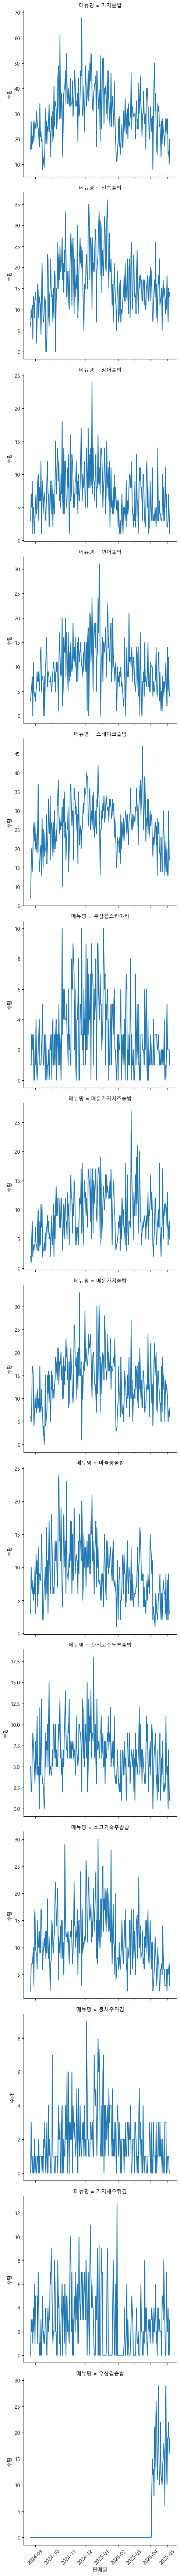

In [23]:
#메뉴별 시각화

g = sns.FacetGrid(daily_df, col="메뉴명", col_wrap=1, height=5, sharey=False)

g.map_dataframe(sns.lineplot, x="판매일", y="수량")


for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3-1.이상치 탐지

In [24]:
#이상치 탐지 
def detect_outliers_iqr_mark(df):
    df = df.copy()
    df['이상치'] = False

    for menu in df['메뉴명'].unique():
        # 해당 메뉴·휴무일 제외한 모든 날짜(0 포함) 집합
        mask_menu = (df['메뉴명'] == menu) & (~df['휴무일'])
        sub = df.loc[mask_menu, '수량']

        # IQR 계산 (0 포함)
        q1 = sub.quantile(0.25)
        q3 = sub.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # 휴무일 제외한 상태에서 이상치 판정 (0도 후보)
        cond = mask_menu & (
            (df['수량'] < lower) | (df['수량'] > upper)
        )

        # 이상치로 마킹 & NaN 처리 (보간 대상)
        df.loc[cond, ['수량', '이상치']] = [np.nan, True]

    return df
daily_df = detect_outliers_iqr_mark(daily_df)

In [25]:
test5 = daily_df[daily_df['이상치']==True].reset_index().copy()
test5

,index,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치
0,4,2024-08-23,스테이크솥밥,NaN,False,False,7.0,True
1,485,2024-09-26,꽈리고추두부솥밥,NaN,False,False,15.0,True
2,571,2024-10-02,통새우튀김,NaN,False,False,7.0,True
3,722,2024-10-13,마늘쫑솥밥,NaN,False,False,23.0,True
4,736,2024-10-14,마늘쫑솥밥,NaN,False,False,24.0,True
...,...,...,...,...,...,...,...,...
68,3541,2025-05-02,우삼겹솥밥,NaN,False,False,19.0,True
69,3555,2025-05-03,우삼겹솥밥,NaN,False,False,19.0,True
70,3569,2025-05-04,우삼겹솥밥,NaN,False,False,22.0,True
71,3583,2025-05-05,우삼겹솥밥,NaN,False,False,16.0,True


In [26]:
test6 = daily_df[daily_df['메뉴명']=='가지솥밥'].reset_index().copy()
test6[test6['이상치']==True]

,index,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치
54,756,2024-10-16,가지솥밥,NaN,False,False,61.0,True
94,1316,2024-11-25,가지솥밥,NaN,False,False,68.0,True


In [27]:
daily_df[daily_df['수량']==0]

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치
11,2024-08-23,통새우튀김,0.0,False,True,0.0,False
12,2024-08-23,가지새우튀김,0.0,False,True,0.0,False
13,2024-08-23,우삼겹솥밥,0.0,False,True,0.0,False
27,2024-08-24,우삼겹솥밥,0.0,False,True,0.0,False
41,2024-08-25,우삼겹솥밥,0.0,False,True,0.0,False
...,...,...,...,...,...,...,...
3551,2025-05-03,꽈리고추두부솥밥,0.0,False,True,0.0,False
3568,2025-05-04,가지새우튀김,0.0,False,True,0.0,False
3581,2025-05-05,통새우튀김,0.0,False,True,0.0,False
3582,2025-05-05,가지새우튀김,0.0,False,True,0.0,False


In [28]:
daily_df[daily_df['수량'].isna()]

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치
4,2024-08-23,스테이크솥밥,NaN,False,False,7.0,True
485,2024-09-26,꽈리고추두부솥밥,NaN,False,False,15.0,True
571,2024-10-02,통새우튀김,NaN,False,False,7.0,True
722,2024-10-13,마늘쫑솥밥,NaN,False,False,23.0,True
736,2024-10-14,마늘쫑솥밥,NaN,False,False,24.0,True
...,...,...,...,...,...,...,...
3541,2025-05-02,우삼겹솥밥,NaN,False,False,19.0,True
3555,2025-05-03,우삼겹솥밥,NaN,False,False,19.0,True
3569,2025-05-04,우삼겹솥밥,NaN,False,False,22.0,True
3583,2025-05-05,우삼겹솥밥,NaN,False,False,16.0,True


# 3-2.이상치 보간

In [29]:
#연속 이상치들을 블록단위로 그룹화 (1) : get_outlier_blocks에 내장될 함수

def group_consecutive_dates(dates):
    if not dates:  # 빈 리스트일 경우 바로 반환
        return []
    
    dates = sorted(dates)
    blocks = []
    block = [dates[0]]
    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days == 1:
            block.append(dates[i])
        else:
            blocks.append(block)
            block = [dates[i]]
    blocks.append(block)
    return blocks


In [30]:
#연속 이상치들을 블록단위로 그룹화 (2)

def get_outlier_blocks(df):
    blocks = []
    for menu in df['메뉴명'].unique():
        menu_df = df[(df['메뉴명'] == menu) & (df['이상치'])]
        grouped = group_consecutive_dates(menu_df['판매일'].tolist())
        for g in grouped:
            blocks.append({
                '메뉴명': menu,
                '시작': g[0],
                '끝': g[-1],
                '길이': len(g)
            })
    return blocks

In [31]:
#연속 이상치들을 블록단위로 그룹화 (2)

def interpolate_block(df, block, method='linear'):
    # 해당 메뉴의 전체 시계열 가져오기 + 정렬
    menu_df = df[df['메뉴명'] == block['메뉴명']].sort_values('판매일').copy()

    # 판매일을 인덱스로 설정 (보간용 기준 키)
    menu_df.set_index('판매일', inplace=True)

    # 보간 방식 결정
    if block['길이'] == 1:
        # 단일 이상치 → Cubic Spline 보간
        menu_df['수량'] = menu_df['수량'].interpolate(method='spline', order=3)
    else:
        # 연속 이상치 → 선형 또는 다항 보간
        menu_df['수량'] = menu_df['수량'].interpolate(method=method)

    # 원본 df에서 block 구간 마스킹
    mask = (
        (df['메뉴명'] == block['메뉴명']) &
        (df['판매일'] >= block['시작']) &
        (df['판매일'] <= block['끝'])
    )

    # 보간된 수량을 판매일 기준으로 매핑하여 원본 df에 적용
    df.loc[mask, '수량'] = df.loc[mask, '판매일'].map(menu_df['수량'])

    return df

In [32]:
#이상치 보간
blocks = get_outlier_blocks(daily_df)

for block in blocks:  # block은 이제 dict 하나씩
    daily_df = interpolate_block(daily_df, block, method='linear') 
    #연속보간에 linear말고 다항이나 또다른 보간법 집어넣을수 있음


In [33]:
daily_df[daily_df['이상치']==True]

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치
4,2024-08-23,스테이크솥밥,NaN,False,False,7.0,True
485,2024-09-26,꽈리고추두부솥밥,8.838201,False,False,15.0,True
571,2024-10-02,통새우튀김,0.407122,False,False,7.0,True
722,2024-10-13,마늘쫑솥밥,10.666667,False,False,23.0,True
736,2024-10-14,마늘쫑솥밥,12.333333,False,False,24.0,True
...,...,...,...,...,...,...,...
3541,2025-05-02,우삼겹솥밥,0.000000,False,False,19.0,True
3555,2025-05-03,우삼겹솥밥,0.000000,False,False,19.0,True
3569,2025-05-04,우삼겹솥밥,0.000000,False,False,22.0,True
3583,2025-05-05,우삼겹솥밥,0.000000,False,False,16.0,True


# 4.평가치 판단 및 해석

In [34]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def eval_one(menu=None):
    sub = daily_df if menu is None else daily_df[daily_df['메뉴명']==menu]
    mask = sub['수량_원본'].notna() & sub['수량'].notna()
    if mask.sum()==0:         # 비교할 게 없으면 NaN 반환
        return np.nan, np.nan
    mae  = mean_absolute_error(sub.loc[mask,'수량_원본'],
                               sub.loc[mask,'수량'])
    rmse = root_mean_squared_error(sub.loc[mask,'수량_원본'],
                                   sub.loc[mask,'수량'])
    return mae, rmse

In [35]:
results = []
for menu in daily_df['메뉴명'].unique():
    mae, rmse = eval_one(menu)
    results.append({'메뉴명':menu, 'MAE':mae, 'RMSE':rmse})

mae_all, rmse_all = eval_one()      # 전체
results.append({'메뉴명':'전체', 'MAE':mae_all, 'RMSE':rmse_all})

metric_df = pd.DataFrame(results)
print(metric_df)

         메뉴명       MAE      RMSE
0       가지솥밥  0.237063  2.688828
1       전복솥밥  0.021409  0.249497
2       장어솥밥  0.168608  1.502106
3       연어솥밥  0.118414  0.997933
4     스테이크솥밥  0.043241  0.691863
5    우삼겹스키야키  0.180138  1.088504
6   매운가지치즈솥밥  0.051836  0.830987
7     매운가지솥밥  0.076585  1.227749
8      마늘쫑솥밥  0.162747  1.535560
9   꽈리고추두부솥밥  0.103144  0.988087
10   소고기숙주솥밥  0.208204  1.817909
11     통새우튀김  0.094542  0.702840
12    가지새우튀김  0.000000  0.000000
13     우삼겹솥밥  2.116732  6.182692
14        전체  0.255964  2.066383


| 메뉴명             | MAE      | RMSE     | 해석                                                         |
|------------------|----------|----------|------------------------------------------------------------|
| **가지솥밥**        | 0.24     | 2.69     | 하루 평균 0.24그릇, 큰 날 ±2.7 → 무난한 수준                      |
| **전복솥밥**        | 0.02     | 0.25     | 사실상 오차 0, 완벽에 가까운 복원                                 |
| **장어솥밥**        | 0.17     | 1.50     | 약간의 오차 있지만, 실사용엔 문제 없는 수준                          |
| **연어솥밥**        | 0.12     | 1.00     | 오차 적고 자연스러운 흐름                                       |
| **스테이크솥밥**     | 0.04     | 0.69     | 아주 안정적, 보간 필요성도 낮았을 듯                                |
| **우삼겹스키야키**    | 0.18     | 1.09     | 양호. CS 보간이 잘 작동한 듯                                   |
| **매운가지치즈솥밥**  | 0.05     | 0.83     | 아주 안정적인 보간 결과                                       |
| **매운가지솥밥**     | 0.08     | 1.23     | 보통 수준. 특별히 튀는 날은 있었던 듯                               |
| **마늘쫑솥밥**       | 0.16     | 1.54     | 오차 약간 있으나 수용 가능                                     |
| **꽈리고추두부솥밥**  | 0.10     | 0.99     | 평균 수준. 괜찮은 보간                                       |
| **소고기숙주솥밥**    | 0.21     | 1.82     | 보통 이상의 오차. 실제 수요 변동이 컸을 수 있음                       |
| **통새우튀김**       | 0.09     | 0.70     | 큰 문제 없음. 자연스럽게 보간                                    |
| **가지새우튀김**     | 0.00     | 0.00     | 보간된 지점이 없거나, 원본과 완벽 일치                               |
| **우삼겹솥밥**       | **2.12** | **6.18** | 오차 매우 큼. 보간 길이가 길거나, 수요 자체가 불규칙했을 가능성             |
| **전체 평균**       | 0.26     | 2.07     | 전반적으로 하루 0.26그릇 오차, 큰 날 ±2그릇 정도로 안정적                 |


## 해석


전복솥밥, 가지새우튀김: 보간 완벽. 이 메뉴는 거의 변경이 없거나 실제 판매량과 동일.

우삼겹솥밥: 명백한 문제 메뉴. 오차가 다른 메뉴보다 10배 이상 크다.

가능한 이유:

휴무일 또는 이상치가 많았거나

원래 수요 자체가 들쭉날쭉한 고변동 메뉴

나머지 대부분의 메뉴는 MAE가 0.1 to 0.2, RMSE는 1 to 2 사이로 안정적

C:\Users\pider\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  self._figure.tight_layout(*args, **kwargs)


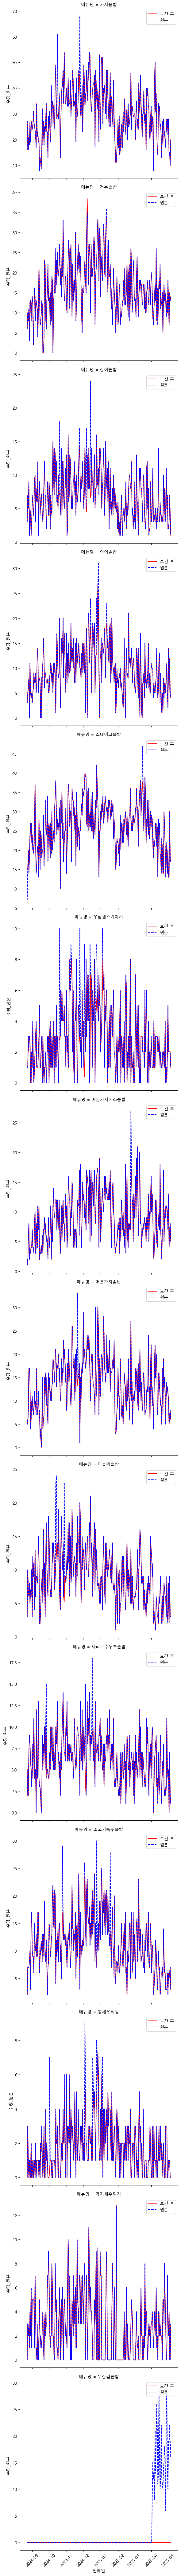

In [36]:
# 그리드 생성
g = sns.FacetGrid(daily_df, col="메뉴명", col_wrap=1, height=6, sharey=False)

# 보간 후 수량 (진한 선)
g.map_dataframe(sns.lineplot, x="판매일", y="수량", label="보간 후", color='red')

# 보간 전 수량 (점선 또는 흐릿한 선)
g.map_dataframe(sns.lineplot, x="판매일", y="수량_원본", label="원본", color='blue', linestyle='--')

# 범례와 눈금 회전
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    if not ax.legend_:
        ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

# 5.daily_df의 수량에 대한 MinMax 정규화 진행

In [37]:
from sklearn.preprocessing import MinMaxScaler

def normalize_by_menu(df):
    result = df.copy()
    result['수량_정규화'] = 0.0

    for menu in result['메뉴명'].unique():
        mask = result['메뉴명'] == menu
        scaler = MinMaxScaler()

        values = result.loc[mask, '수량'].values.reshape(-1, 1)
        scaled = scaler.fit_transform(values)

        result.loc[mask, '수량_정규화'] = scaled.flatten()

    return result
daily_df = normalize_by_menu(daily_df)

In [38]:
daily_df.groupby('메뉴명')['수량_정규화'].agg(['min', 'max'])


,min,max
메뉴명,,
가지새우튀김,0.0,1.0
가지솥밥,0.0,1.0
꽈리고추두부솥밥,0.0,1.0
마늘쫑솥밥,0.0,1.0
매운가지솥밥,0.0,1.0
매운가지치즈솥밥,0.0,1.0
소고기숙주솥밥,0.0,1.0
스테이크솥밥,0.0,1.0
연어솥밥,0.0,1.0


# 6.파생 변수 생성 

### 날짜 기반 파생변수 (요일 주말 월 분기 주차 공휴일)

In [39]:
#공휴일 리스트
holidays = ['2024-01-01', '2024-02-09', '2024-02-10', 
            '2024-02-11', '2024-02-12', '2024-03-01',
            '2024-04-10', '2024-05-01', '2024-05-05',
            '2024-05-06', '2024-06-06', '2024-08-15',
            '2024-09-16', '2024-09-17', '2024-09-18',
            '2024-10-03', '2024-10-09', '2024-12-25']

holidays = pd.to_datetime(holidays)

In [40]:
def add_calendar_features(df):
    df = df.copy()
    df['판매일'] = pd.to_datetime(df['판매일'])

    # 날짜 기반 파생변수 추가
    df['요일'] = df['판매일'].dt.weekday                        # 0=월, 6=일
    df['주말'] = df['요일'].isin([5, 6]).astype(int)            #주말이면 1 반환
    df['월'] = df['판매일'].dt.month
    df['분기'] = df['판매일'].dt.quarter
    df['주차'] = df['판매일'].dt.isocalendar().week.astype(int)
    df['공휴일'] = df['판매일'].isin(holidays).astype(int)     #공휴일이면 1반환
    
    return df

In [41]:
daily_df = add_calendar_features(daily_df)

In [42]:
daily_df[['판매일', '요일', '주말', '월', '분기', '주차','공휴일']].head()

,판매일,요일,주말,월,분기,주차,공휴일
0,2024-08-23,4,0,8,3,34,0
1,2024-08-23,4,0,8,3,34,0
2,2024-08-23,4,0,8,3,34,0
3,2024-08-23,4,0,8,3,34,0
4,2024-08-23,4,0,8,3,34,0


### 시계열 자기회귀 기반 변수 (전날_판매량 & 7일_이동평균_판매량)

In [43]:
def add_lag_features(df):
    df = df.copy()
    df = df.sort_values(['메뉴명', '판매일'])

    # 그룹별로 전날 수량과 7일 이동평균 수량 계산
    df['전날_수량'] = df.groupby('메뉴명')['수량'].shift(1)
    df['7일_이동평균'] = df.groupby('메뉴명')['수량'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

    return df


In [44]:
daily_df = add_lag_features(daily_df)

In [45]:
daily_df[['전날_수량', '7일_이동평균']]

,전날_수량,7일_이동평균
12,NaN,0.000000
26,0.0,1.500000
40,3.0,1.666667
54,2.0,2.000000
68,3.0,1.800000
...,...,...
3539,0.0,1.428571
3553,1.0,1.571429
3567,1.0,1.285714
3581,1.0,0.857143


### 날씨 기반 파생변수

In [70]:
weather_df = pd.read_csv('./data/weather_df.csv', encoding='cp949').copy()
weather_df

,지점,지점명,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10)
0,108,서울,2024-08-23,28.4,0.0,2.7,73.5,5.3
1,108,서울,2024-08-24,27.6,2.0,1.4,78.8,3.8
2,108,서울,2024-08-25,28.5,NaN,1.4,76.6,3.4
3,108,서울,2024-08-26,28.1,0.0,1.5,77.8,8.0
4,108,서울,2024-08-27,26.5,0.3,1.9,69.8,6.1
...,...,...,...,...,...,...,...,...
252,108,서울,2025-05-02,13.4,0.0,3.1,59.3,5.6
253,108,서울,2025-05-03,11.2,7.3,2.3,80.5,6.9
254,108,서울,2025-05-04,13.7,NaN,2.8,60.9,1.1
255,108,서울,2025-05-05,12.1,NaN,2.3,64.5,8.0


In [71]:
weather_df = weather_df.drop(columns=['지점', '지점명'])

In [72]:
weather_df['불쾌지수'] = (
    0.81 * weather_df['평균기온(°C)'] +
    0.01 * weather_df['평균 상대습도(%)'] * (0.99 * weather_df['평균기온(°C)'] - 14.3) +
    46.3
)

In [73]:
weather_df

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10),불쾌지수
0,2024-08-23,28.4,0.0,2.7,73.5,5.3,79.458760
1,2024-08-24,27.6,2.0,1.4,78.8,3.8,78.918912
2,2024-08-25,28.5,NaN,1.4,76.6,3.4,80.043890
3,2024-08-26,28.1,0.0,1.5,77.8,8.0,79.578782
4,2024-08-27,26.5,0.3,1.9,69.8,6.1,76.095630
...,...,...,...,...,...,...,...
252,2025-05-02,13.4,0.0,3.1,59.3,5.6,56.540838
253,2025-05-03,11.2,7.3,2.3,80.5,6.9,52.786340
254,2025-05-04,13.7,NaN,2.8,60.9,1.1,56.948167
255,2025-05-05,12.1,NaN,2.3,64.5,8.0,54.603955


#### 불쾌지수 해석:

공식 :불쾌지수 = 1.8 x 기온 – 0.55 x (1 – 습도) x (1.8 x 기온 – 26) + 32

60-70: 쾌적한 상태입니다. 

70-75: 약간의 불쾌감을 느낄 수 있습니다. 

75-80: 많은 사람들이 불쾌감을 느끼기 시작합니다. 

80 이상: 매우 불쾌하며, 불쾌감과 함께 짜증, 무기력함 등을 느낄 수 있습니다. 

In [74]:
daily_df['판매일'] = pd.to_datetime(daily_df['판매일'])

In [75]:
weather_df['일시'] = pd.to_datetime(weather_df['일시'])

In [76]:
final_merged_df = pd.merge(daily_df, weather_df, left_on='판매일', right_on='일시', how='left')

In [78]:
final_merged_df = final_merged_df.drop(columns=['일시'])

In [79]:
final_merged_df.to_csv("DS_with_weather.csv", index=False, encoding="utf-8-sig")

In [80]:
final_merged_df

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치,수량_정규화,요일,주말,...,주차,공휴일,전날_수량,7일_이동평균,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10),불쾌지수
0,2024-08-23,가지새우튀김,0.0,False,True,0.0,False,0.000000,4,0,...,34,0,NaN,0.000000,28.4,0.0,2.7,73.5,5.3,79.458760
1,2024-08-24,가지새우튀김,3.0,False,False,3.0,False,0.234161,5,1,...,34,0,0.0,1.500000,27.6,2.0,1.4,78.8,3.8,78.918912
2,2024-08-25,가지새우튀김,2.0,False,False,2.0,False,0.156108,6,1,...,34,0,3.0,1.666667,28.5,NaN,1.4,76.6,3.4,80.043890
3,2024-08-26,가지새우튀김,3.0,False,False,3.0,False,0.234161,0,0,...,35,0,2.0,2.000000,28.1,0.0,1.5,77.8,8.0,79.578782
4,2024-08-27,가지새우튀김,1.0,False,False,1.0,False,0.078054,1,0,...,35,0,3.0,1.800000,26.5,0.3,1.9,69.8,6.1,76.095630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,2025-05-02,통새우튀김,1.0,False,False,1.0,False,0.135982,4,0,...,18,0,0.0,1.428571,13.4,0.0,3.1,59.3,5.6,56.540838
3594,2025-05-03,통새우튀김,1.0,False,False,1.0,False,0.135982,5,1,...,18,0,1.0,1.571429,11.2,7.3,2.3,80.5,6.9,52.786340
3595,2025-05-04,통새우튀김,1.0,False,False,1.0,False,0.135982,6,1,...,18,0,1.0,1.285714,13.7,NaN,2.8,60.9,1.1,56.948167
3596,2025-05-05,통새우튀김,0.0,False,True,0.0,False,0.000000,0,0,...,19,0,1.0,0.857143,12.1,NaN,2.3,64.5,8.0,54.603955


# 7.다중 공선성 판단 

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# 1. 전체 수치형 변수 추출
numeric_cols = final_merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2. 결측값 제거 (VIF는 NaN 허용 안됨)
X = final_merged_df[numeric_cols].dropna()

# 3. 상수항 추가 (절편)
X = add_constant(X)

# 4. VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 5. 결과 보기
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,const,1926.246381
6,평균기온(°C),237.870827
11,불쾌지수,225.334324
1,수량,38.791513
2,수량_원본,24.154982
5,7일_이동평균,15.224104
4,전날_수량,7.019282
9,평균 상대습도(%),2.799410
3,수량_정규화,2.794591
10,평균 전운량(1/10),1.904289


결과 해석


평균기온, 불쾌지수, 수량, 수량 원본, 7일이동평균, 전날수량은 관계성 큼


평균 상대습도(%),수량_정규화,평균 전운량(1/10),일강수량(mm),평균 풍속(m/s) 는 모두 독립변수로 해석가능


# 8.차원축소

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1. 수치형 변수 추출
numeric_cols = final_merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
X = final_merged_df[numeric_cols].dropna()

# 모든 수치형 컬럼을 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA 적용
pca = PCA(n_components=3)  # 필요 시 조정 가능
X_pca = pca.fit_transform(X_scaled)

# 4. 결과만 담은 새 데이터프레임 생성
pca_df = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2', 'pca_3'])

# 5. 확인
pca_df.head()

,pca_1,pca_2,pca_3
0,-2.279833,1.338919,-2.312007
1,-2.347195,1.915441,-1.762306
2,-2.485773,1.006940,-1.814200
3,-1.582109,1.367505,-0.805169
4,-2.580014,1.888602,-0.539529


In [83]:
print("각 주성분이 설명하는 분산 비율:", pca.explained_variance_ratio_)
print("누적 설명력:", pca.explained_variance_ratio_.cumsum())

각 주성분이 설명하는 분산 비율: [0.38977206 0.24573611 0.12633065]
누적 설명력: [0.38977206 0.63550817 0.76183882]


### 해석
각 주성분의 설명을 비율로 표현한것으로

이 세가지 성분을 통해 전체 데이터의 76%를 설명할 수 있게 된것임

원래있던 11개의 변수를 3개로 통합하면서도 3/4이상의 정보를 유지한것이므로 좋은 수치

In [84]:
# 변수 기여도 확인 (각 변수들이 주성분에 얼마나 기여했는지)
pca_components = pd.DataFrame(pca.components_, columns=numeric_cols, index=['pca_1', 'pca_2', 'pca_3'])
pca_components.T.sort_values(by='pca_1', ascending=False)

,pca_1,pca_2,pca_3
수량,0.459799,0.152082,0.003814
수량_원본,0.453823,0.150896,0.002892
7일_이동평균,0.442853,0.145875,0.050419
전날_수량,0.422367,0.152902,0.018926
수량_정규화,0.344604,0.039467,-0.047521
평균 풍속(m/s),0.017556,-0.201537,0.463911
일강수량(mm),-0.105981,0.311561,0.518241
평균 전운량(1/10),-0.122161,0.381817,0.402654
평균 상대습도(%),-0.123470,0.418917,0.279719
불쾌지수,-0.152489,0.466015,-0.376961


### pac_1해석

pac_1: 주로 수량관련 변수들로 구성
    수량, 수량_원본, 7일_이동평균, 전날_수량 : 0.42~0.46
    수량_정규화 : 0.34

    전반적인 판매량 규모, 수요의 절대량과 관련된 축임
pca_1이 클수록 → 전반적으로 많이 팔리는 날

pca_1이 작을수록 → 적게 팔리는 날.

### pac_2해석

pac_2: 주로 기온과 습도 관련 변수들로 구성
    평균기온(°C) : 0.48
    불쾌지수 : 0.46
    평균 상대습도(%), 전운량, 강수량 : 0.31~0.41

    날씨 컨디션이 얼마나 안좋은가, 불쾌한가를 나타내는 축임
pca_2이 클수록 → 더 덥고 습하며 불쾌지수가 높은 날

pca_2이 작을수록 → 시원하고 건조한 날.

### pac_3해석

pac_3: 주로 풍속, 강수량, 구름 관련 변수들로 구성
    평균풍속 : 0.46
    일강수량 : 0.52
    전운량, 습도 : 보조적 기여

    비오고 바람이 많이 부는 날씨를 나타내는 축임
pca_3이 클수록 → 비 바람 구름이 많은 날씨

pca_3이 작을수록 → 잔잔한 날씨

# 9.컬럼별 중요도 판단(feature importance)

In [88]:
corr_result = final_merged_df.corr(numeric_only=True)['수량'].sort_values(key=abs, ascending=False)
print(corr_result)

수량              1.000000
수량_원본           0.978468
7일_이동평균         0.923059
전날_수량           0.850186
수량_정규화          0.696705
미판매일           -0.371693
평균기온(°C)       -0.106420
불쾌지수           -0.105734
분기              0.080976
월               0.079705
일강수량(mm)       -0.076737
주차              0.070382
이상치            -0.058962
평균 상대습도(%)     -0.057198
평균 전운량(1/10)   -0.056775
평균 풍속(m/s)     -0.049401
주말             -0.036641
공휴일            -0.031796
요일             -0.030835
휴무일            -0.013139
Name: 수량, dtype: float64


### 해석

상관관계 분석시

선형적인관계를 보았을떄 크게 관련이있는 독립변수는 없다

### 선형회귀 분석

In [89]:
from sklearn.linear_model import LinearRegression

# 1. 수치형 변수 추출 (수량 제외)
features = final_merged_df.select_dtypes(include=['float64', 'int64']).drop(columns=['수량']).dropna()
target = final_merged_df.loc[features.index, '수량']

# 2. 표준화 (해석 편의를 위해)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. 선형회귀 학습
model = LinearRegression()
model.fit(X_scaled, target)

# 4. 계수 확인
coefficients = pd.Series(model.coef_, index=features.columns).sort_values(key=abs, ascending=False)
print(coefficients)


수량_원본           6.176793
7일_이동평균         2.742601
수량_정규화          1.260669
불쾌지수            0.880192
평균기온(°C)       -0.689853
평균 상대습도(%)      0.142939
평균 풍속(m/s)      0.085651
평균 전운량(1/10)   -0.081388
일강수량(mm)       -0.044500
전날_수량           0.036975
dtype: float64


### 해석

독립적인 변수만 보자( 불쾌지수, 평균기온, 평균상대습도, 평균풍속, 평균 전운량, 일강수량)

불쾌지수	0.88  : 불쾌지수가 1 높아지면 수량이 0.88 증가.  → 덥고 습할수록 수요가 올라갈 수 있다는 암시

평균기온(°C)	-0.69 : 기온이 1도 높아질 때 수량은 약 0.69 감소 → 반비례 경향.



In [97]:
final_merged_df

,판매일,메뉴명,수량,휴무일,미판매일,수량_원본,이상치,수량_정규화,요일,주말,...,주차,공휴일,전날_수량,7일_이동평균,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10),불쾌지수
0,2024-08-23,가지새우튀김,0.0,False,True,0.0,False,0.000000,4,0,...,34,0,NaN,0.000000,28.4,0.0,2.7,73.5,5.3,79.458760
1,2024-08-24,가지새우튀김,3.0,False,False,3.0,False,0.234161,5,1,...,34,0,0.0,1.500000,27.6,2.0,1.4,78.8,3.8,78.918912
2,2024-08-25,가지새우튀김,2.0,False,False,2.0,False,0.156108,6,1,...,34,0,3.0,1.666667,28.5,NaN,1.4,76.6,3.4,80.043890
3,2024-08-26,가지새우튀김,3.0,False,False,3.0,False,0.234161,0,0,...,35,0,2.0,2.000000,28.1,0.0,1.5,77.8,8.0,79.578782
4,2024-08-27,가지새우튀김,1.0,False,False,1.0,False,0.078054,1,0,...,35,0,3.0,1.800000,26.5,0.3,1.9,69.8,6.1,76.095630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,2025-05-02,통새우튀김,1.0,False,False,1.0,False,0.135982,4,0,...,18,0,0.0,1.428571,13.4,0.0,3.1,59.3,5.6,56.540838
3594,2025-05-03,통새우튀김,1.0,False,False,1.0,False,0.135982,5,1,...,18,0,1.0,1.571429,11.2,7.3,2.3,80.5,6.9,52.786340
3595,2025-05-04,통새우튀김,1.0,False,False,1.0,False,0.135982,6,1,...,18,0,1.0,1.285714,13.7,NaN,2.8,60.9,1.1,56.948167
3596,2025-05-05,통새우튀김,0.0,False,True,0.0,False,0.000000,0,0,...,19,0,1.0,0.857143,12.1,NaN,2.3,64.5,8.0,54.603955


## 랜덤포레스트 기반 분석

In [98]:
features = [
    '평균기온(°C)', '불쾌지수', '일강수량(mm)', '평균 풍속(m/s)',
    '평균 상대습도(%)', '평균 전운량(1/10)', '주말', '공휴일', '요일', '월', '주차', '분기'
]

target = '수량'

In [104]:
from sklearn.model_selection import train_test_split

# 피처 + 타겟을 함께 묶어서 결측 제거
df_sub = final_merged_df[features + [target]].dropna()

# 다시 분리
X = df_sub[features]
y = df_sub[target]

# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [102]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

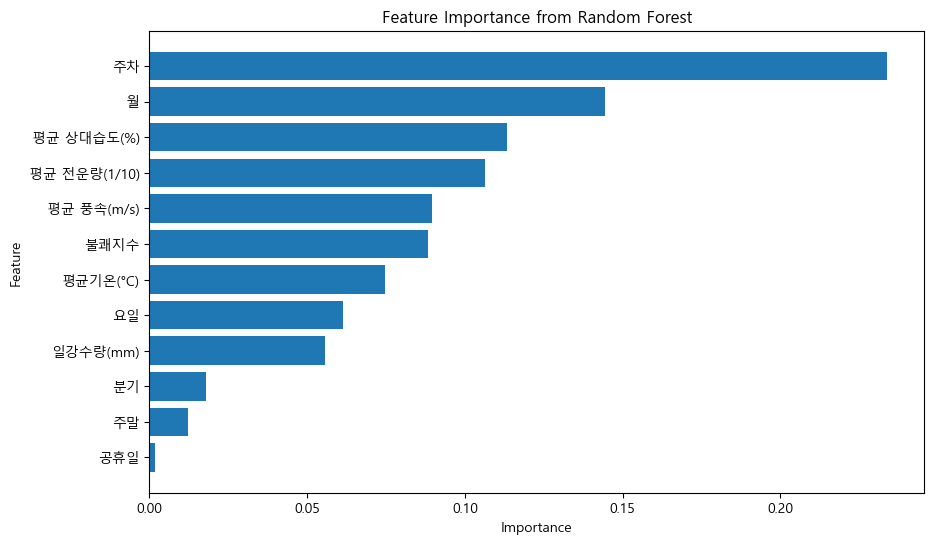

In [103]:
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

### 해석


주차가 0.2를 넘기므로 다른 피처에 비해 중요한 변수이다..

이 변수가 전체 예측의 패턴을 주도햘 가능성이 높다

# 7. CSV 파일로 변환

In [ ]:
daily_df.to_csv("DS_preprocessing.csv", index=False, encoding="utf-8-sig")

In [ ]:
import os, glob
print(os.getcwd())        # 현재 작업 경로
print(glob.glob("*.csv")) # 현재 폴더의 CSV 목록


미판매일 차원축소(다중공선성) 같은것끼리 컬럼명에 표시
IQR 1.5로 나온 이상치가 진짜 의미있는가?

차원 축소한 데이터셋

In [87]:
pca_df.to_csv("DS_pca.csv", index=False, encoding="utf-8-sig")